#Что сделать:

0. preprocessing текста (токенизация, стоп слова, стемминг и т.д.)
1. Составить эмбединги слов с помощью Gensim Word2Vec
2. Вывести эмбеденги некоторых слов
3. Посмотреть на логичность этих эмбедингов, посмотреть похожие слова, вывести разницу некоторых слов, можно визуализировать пространство
 

In [142]:
import re
from collections import Counter
from tqdm.notebook import tqdm
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from catalyst import dl
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
!pip install contractions
import contractions
nltk.download("stopwords")
from nltk.corpus import stopwords
import multiprocessing

from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
df = pd.read_csv("../input/dialogue-lines-of-the-simpsons/simpsons_dataset.csv")
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [71]:
# Есть пропуски
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [72]:
#Почистим, теперь пропусков нет
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [73]:
#131к диалогов
len(df)

131853

In [75]:
#Сначала сделаем все маленькими буквами
df["spoken_words"] = df["spoken_words"].apply(lambda x: x.lower())
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"no, actually, it was a little of both. sometim..."
1,Lisa Simpson,where's mr. bergstrom?
2,Miss Hoover,i don't know. although i'd sure like to talk t...
3,Lisa Simpson,that life is worth living.
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...


In [76]:
#Expand the Contractions (we'll -> we will or we shouldn't've -> we should not have)
df["spoken_words"] = df["spoken_words"].apply(lambda x: contractions.fix(x))
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"no, actually, it was a little of both. sometim..."
1,Lisa Simpson,where is mr. bergstrom?
2,Miss Hoover,i do not know. although i would sure like to t...
3,Lisa Simpson,that life is worth living.
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...


In [77]:
#Здесь различные функции по очистке от URL, HTML, спец. символы, эмоджи и т.д. 
#В нашем случае понадобится только удалить пунктуацию, т.е. воспользуемся только функцией remove_punct()
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!“”"$%&\'()-*+,’./:;=#@?[\'\^_`{|}~-—]+', "", text)
    #return text.translate(str.maketrans('', '', string.punctuation))

def other_clean(text):
        """
            Replace the Typos, slang, acronyms or informal abbreviations:
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [78]:
#Убираем пунктуацию
df["spoken_words"] = df["spoken_words"].apply(lambda x: remove_punct(x))
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,no actually it was a little of both sometimes ...
1,Lisa Simpson,where is mr bergstrom
2,Miss Hoover,i do not know although i would sure like to ta...
3,Lisa Simpson,that life is worth living
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...


In [ ]:
#Есть еще пакет для исправления грамматики. В нашем случае текст из книги, а значет грамматика в порядке - пользоваться не будем.
from textblob import TextBlob
print("Test: ", TextBlob("sleapy and tehre is no plaxe I'm gioong to.").correct())

In [87]:
#Сократим датафрейм в 2 раза,чтобы все было быстрее
df_half = df.iloc[:60000, ]
df_half

,raw_character_text,spoken_words
0,Miss Hoover,no actually it was a little of both sometimes ...
1,Lisa Simpson,where is mr bergstrom
2,Miss Hoover,i do not know although i would sure like to ta...
3,Lisa Simpson,that life is worth living
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...
...,...,...
59995,BUCK,remember kids drunken cowboy brand whiskey is ...
59996,Marge Simpson,i am not sure i approve of selling whiskey to ...
59997,BUCK,well that ad was aimed at children who were al...
59998,Marge Simpson,oh


In [88]:
#Лемматизация
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 1579298
df_half["lemm"] = df_half["spoken_words"].apply(lambda x:' '.join([token.lemma_ for token in nlp(x)]))
df_half.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,raw_character_text,spoken_words,lemm
0,Miss Hoover,no actually it was a little of both sometimes ...,no actually it be a little of both sometimes w...
1,Lisa Simpson,where is mr bergstrom,where be mr bergstrom
2,Miss Hoover,i do not know although i would sure like to ta...,I do not know although I would sure like to ta...
3,Lisa Simpson,that life is worth living,that life be worth live
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...,the poll will be open from now until the end o...


In [89]:
#Увидели что все хорошо, можем убирать ненужные колонки
df_half = df_half["lemm"]
df_half

0        no actually it be a little of both sometimes w...
1                                    where be mr bergstrom
2        I do not know although I would sure like to ta...
3                                  that life be worth live
4        the poll will be open from now until the end o...
                               ...                        
59995    remember kid drunken cowboy brand whiskey be s...
59996     I be not sure I approve of sell whiskey to child
59997    well that ad be aim at child who be already he...
59998                                                   oh
59999         tonight episode scuse I while I kill the sky
Name: lemm, Length: 60000, dtype: object

In [102]:
#Убираем стоп-слова из пакета stopwords (делаем свою функцию чтобы потокеново проходится по словам)
stop = set(stopwords.words('english'))

def stopwordsMY(x):
    x = x.split()
    x = [word for word in x if word not in stop]
    return ' '.join(x)
df_half = df_half.apply(lambda x: stopwordsMY(x))
df_half

0        actually little sometimes disease magazine new...
1                                             mr bergstrom
2        I know although I would sure like talk touch l...
3                                          life worth live
4        poll open end recess case decide put thought f...
                               ...                        
59995    remember kid drunken cowboy brand whiskey smoo...
59996                  I sure I approve sell whiskey child
59997              well ad aim child already heavy drinker
59998                                                   oh
59999                   tonight episode scuse I I kill sky
Name: lemm, Length: 60000, dtype: object

In [106]:
#Теперь пройдемся Phraser'ом чтобы распознать популярные биграммы. Чтобы, например, Bart Simpson стал Bart_Simpson. Для этого нужно сделать
# list из list'ов предложений (для этого делаем sent)
sent = [row.split() for row in df_half]

In [112]:
phrases = Phrases(sent, min_count=30, progress_per=5000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [116]:
#Посмотрим на самые популярные слова
from collections import defaultdict 
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['I', '-', 'get', 'go', 'oh', 'well', 'know', 'hey', 'like', 'one']

In [118]:
#Спецификация модели
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [119]:
#Перед обучением нужно сделать build_vocab на нашем корпусе sentences
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [120]:
#Обучаем
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.45 mins


In [152]:
#2. Выведем эмбединг какого-нибудь слова
word_vectors = w2v_model.wv
for i in word_vectors:
    print(i)
    print(len(i))
    break

[ 0.03276637  0.13596818  0.08097401  0.13146675  0.083118   -0.05227354
  0.01765369  0.17987707 -0.11662796 -0.0501705   0.23430444 -0.18630835
 -0.12608764 -0.10494351 -0.20424135 -0.05282172  0.06889955 -0.03983078
 -0.08355265 -0.1752931  -0.00866899 -0.02332359  0.28119573 -0.04718809
  0.3233419   0.0967876  -0.15172835 -0.03412732 -0.053304   -0.41492996
 -0.0652995  -0.17456558  0.09421332  0.01257134  0.03413311  0.12985204
  0.3229664  -0.32656723 -0.07836664 -0.03430811 -0.11585568 -0.1913778
 -0.24636267 -0.10066342  0.0426957  -0.04654329  0.03624164  0.11867232
 -0.01912839  0.32608026 -0.05229653  0.00666977 -0.06234919  0.03555065
 -0.01838914  0.41513616  0.09131151 -0.24211423 -0.05291596  0.38269916
 -0.04683197 -0.23699854 -0.02792288 -0.19485483  0.1036122   0.10733286
 -0.00145443  0.11187672 -0.02793602  0.13854223  0.036167    0.11097174
  0.09301337 -0.02361346  0.02536167  0.21927194  0.03265905  0.1794068
 -0.11110163 -0.14928196 -0.2643357  -0.12834366  0.0

In [132]:
#3. Посмотрим наиболее похожие слова. Выглядит хорошо
w2v_model.wv.most_similar(positive=["car"])

[('drive', 0.9185751676559448),
 ('speed', 0.8839955925941467),
 ('fast', 0.8783997297286987),
 ('wheel', 0.8680465221405029),
 ('window', 0.8347334265708923),
 ('zone', 0.8315963745117188),
 ('ride', 0.8303559422492981),
 ('move', 0.8290596604347229),
 ('truck', 0.8286561965942383),
 ('away', 0.8264145255088806)]

In [134]:
w2v_model.wv.most_similar(positive=["taste"])

[('bacon', 0.9037519693374634),
 ('steak', 0.8914400935173035),
 ('drink', 0.884939968585968),
 ('orange', 0.8841465711593628),
 ('soft', 0.8823615312576294),
 ('syrup', 0.880792498588562),
 ('bucket', 0.8766875267028809),
 ('toast', 0.8755668997764587),
 ('smell', 0.873210608959198),
 ('food', 0.8716886043548584)]

In [133]:
w2v_model.wv.most_similar(positive=["bart"])

[('glad', 0.9222954511642456),
 ('lisa', 0.917522668838501),
 ('sister', 0.9168472290039062),
 ('brother', 0.9154636263847351),
 ('dad', 0.906726062297821),
 ('maggie', 0.9061996936798096),
 ('mom', 0.9031890630722046),
 ('appreciate', 0.9022043347358704),
 ('sweetie', 0.898604154586792),
 ('whatever', 0.8972688913345337)]

In [139]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('ignore', 0.8892542123794556),
 ('folk', 0.8882235288619995),
 ('move', 0.8869496583938599)]

In [144]:
#Визуализация
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


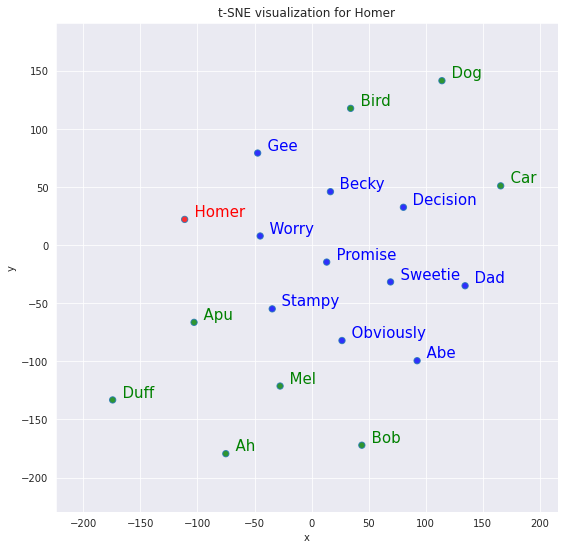

In [146]:
#Похожие слова и 8 рандомных
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'car', 'bob', 'mel', 'apu', 'duff'])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


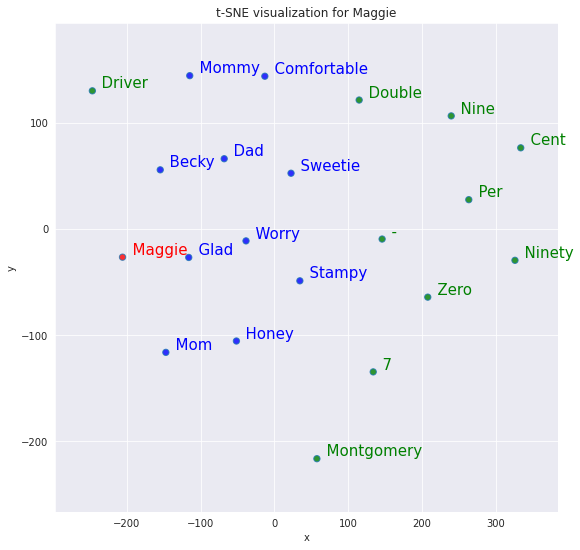

In [147]:
#Похожие и непохожие 
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

In [153]:
#4. Загрузим pretrained embeddings, посмотрим на похожие слова
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")
model.most_similar("bart")

[==================================================] 100.0% 66.0/66.0MB downloaded


[('marge', 0.7120521068572998),
 ('milhouse', 0.6718010902404785),
 ('doggett', 0.66993647813797),
 ('capps', 0.6496360301971436),
 ('freundlich', 0.6353176236152649),
 ('logan', 0.6311033368110657),
 ('rimsza', 0.6234705448150635),
 ('tyler', 0.6209611296653748),
 ('carrie', 0.6199015974998474),
 ('affleck', 0.6172687411308289)]